===================================================
## 4. POD-GAN-deriv
#### DCGAN trained to predict the next increment $\alpha_{n+1} = \Delta t f(\alpha_n) + \alpha_n$

#### Tianyi Zhao
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

NameError: name 'notebookName' is not defined

In [3]:
notebookName = 'GAN-deriv-4.ipynb'

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tf.random.set_seed(42)
seed(42)

In [6]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n',value) # MUST RETURN True IF IT CAN!!
print('\n')
print("***Num GPUs Available: ***\n", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.set_soft_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
***If TF can access GPU: ***
 True


***Num GPUs Available: ***
 1


## Load data

In [7]:
data_dir = './../data/single_domain/'
pod_coeffs = np.load(data_dir + 'pod_coeffs_1.npy') 
pod_coeffs.shape

(1, 10, 1999)

In [8]:
npod = 5
X_pod = np.transpose(pod_coeffs.reshape(10, 1999)[:npod])
step = 0.25
times = np.arange(0, len(X_pod)*step, step, dtype="float64")

X_pod.shape

(1999, 5)

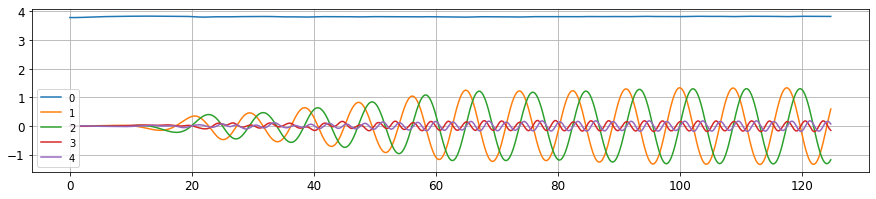

In [9]:
fig, ax = plt.subplots(1,1, figsize=[15,3])
ax.plot(times[0:500], X_pod[0:500]);
ax.grid()
ax.legend(range(5),loc='lower left')

## Prepare data

In [10]:
def calculate_deriv(X_train, step=step):
    """
    Calculate the 1st order time derivative by (a_n+1 - a_n)/step.
    """
    X_deriv = [[] for i in range(len(X_train)-1)]
    for i in range(len(X_deriv)):
        for j in range(5):
            X_deriv[i].append((X_train[i+1, j] - X_train[i, j]) / step)
    return np.array(X_deriv)

In [11]:
X_deriv_1 = calculate_deriv(X_pod, step=step)
X_deriv_2 = calculate_deriv(X_deriv_1, step=step)
X_deriv_3 = calculate_deriv(X_deriv_2, step=step)
X_deriv_4 = calculate_deriv(X_deriv_3, step=step)

#a0, (a1-a0)/t, ((a2-a1)-(a1-a0))/t^2, ...
X_train = np.concatenate((X_pod[:-4], X_deriv_1[:-3], X_deriv_2[:-2], X_deriv_3[:-1], 
                          X_deriv_4), axis=1)
X_train.shape

(1995, 25)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
np.allclose(X_train, scaler.inverse_transform(X_train_scaled))

True

In [13]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train)-ntimes*step):
        X_current = X_train[i:i+ntimes*step:step] # [start_idx:end_idx:step]
        X_train_concat.append(X_current)
    return np.array(X_train_concat)

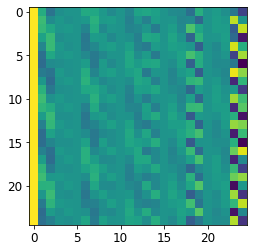

In [14]:
nderiv = 4
ninput = npod*(nderiv+1)

ntimes = 25 # Consecutive times for the GAN
level_step = 4 # step between time levels
nstep = step*level_step

X_pod_concat = concat_timesteps(X_train, ntimes, level_step)
X_pod_concat_flatten = X_pod_concat.reshape(X_pod_concat.shape[0], ntimes*ninput)
plt.imshow(X_pod_concat[500, :, :])

(1895, 25, 25)


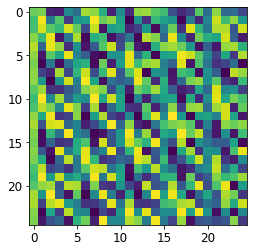

In [15]:
X_train_concat = concat_timesteps(X_train_scaled, ntimes, level_step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], ntimes*ninput)

print(X_train_concat.shape)
plt.imshow(X_train_concat[500, :, :])

## Train the GAN

In [16]:
import wandb

# Initialize a new run and set hyperparameters
#wandb.login(key='356a5933239117f23bf9483081f3ca58e5efbe8b')
wandb.init(project='tsp-ai', group='single_domain', entity='tinayzh')
wandb.watch_called = False  # Re-run the model without restarting the runtime, unnecessary after our next release

# config is a variable that holds and saves hyper parameters and inputs
config = wandb.config  # Initialize config

config.datagroup = 'new' #'new_submean'
config.npod = npod
config.ndomain = 1
config.nderiv_order = nderiv
config.ntimes = ntimes # Consecutive times for the GAN
config.ntime_step = level_step # step between time levels

#config.seed = 42  # random seed(default:42)
config.batch_size = 16  # input batch size for training (default:64)
config.latent_space = 100

config.architechture = 'DCGAN'
config.d_dropout = 0.3
config.optimizer = 'Adam'
config.g_lr = 1e-4  # learning rate(default:0.01)
config.d_lr = 1e-4  # learning rate(default:0.01)

config.epochs = 5000  # number of epochs to train(default:10)
#config.no_cuda = False  # disables CUDA training
config.log_interval = 10  # how many batches to wait before logging training status

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tinayzh (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [17]:
BATCH_SIZE = config.batch_size
latent_space = config.latent_space
d_dropout = config.d_dropout
g_lr = config.g_lr
d_lr = config.d_lr
epochs = config.epochs

In [18]:
# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, ninput, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
for data in train_dataset:
    print(data)
    break

tf.Tensor(
[[[[0.57822293]
   [0.09301554]
   [0.68515044]
   ...
   [0.5505692 ]
   [0.10175568]
   [0.7045317 ]]

  [[0.5636999 ]
   [0.07317678]
   [0.37026116]
   ...
   [0.27453426]
   [0.52984697]
   [0.0386319 ]]

  [[0.619296  ]
   [0.26564965]
   [0.11998777]
   ...
   [0.05409255]
   [0.7446676 ]
   [0.94301707]]

  ...

  [[0.68641245]
   [0.9683621 ]
   [0.33631665]
   ...
   [0.6536828 ]
   [0.81382704]
   [0.43607858]]

  [[0.69060534]
   [0.9617881 ]
   [0.6831613 ]
   ...
   [0.872679  ]
   [0.3909956 ]
   [0.9830105 ]]

  [[0.79258907]
   [0.7303294 ]
   [0.939705  ]
   ...
   [0.9054636 ]
   [0.16773114]
   [0.13712972]]]


 [[[0.49641284]
   [0.76901287]
   [0.23907378]
   ...
   [0.42607462]
   [0.44633475]
   [0.2641529 ]]

  [[0.44663006]
   [0.88650626]
   [0.47863188]
   ...
   [0.59053206]
   [0.761579  ]
   [0.6219838 ]]

  [[0.4665472 ]
   [0.8180842 ]
   [0.7434354 ]
   ...
   [0.8079862 ]
   [0.17575395]
   [0.80053324]]

  ...

  [[0.60699576]
   [0.183193

In [19]:
def make_generator_model():
    model = tf.keras.Sequential()
    # input: nz=5, ngf=5
    model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(latent_space,)))
    #model.add(keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((7, 7, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', output_padding=[0,0], use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model

In [20]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

(1, 25, 25, 1)


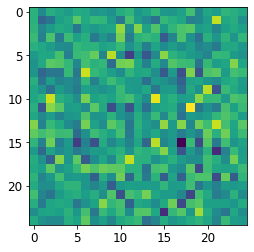

In [21]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[ntimes, ninput, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(d_dropout))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(d_dropout))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [23]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [24]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00205432]], shape=(1, 1), dtype=float32)


In [25]:
gan = keras.models.Sequential([generator, discriminator])

In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [27]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(g_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(d_lr)

In [28]:
# We will reuse this seed overtime 
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [29]:
# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/' + notebookName[:-6] + '/generator'
discriminator_log_dir = './logs/' + notebookName[:-6] + '/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

In [30]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, latent_space])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    generator_mean_loss(gen_loss)
    discriminator_mean_loss(disc_loss)


In [31]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:
            train_step(batch)
            
        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])
        
        # wandb.log is used to record some logs (accuracy, loss and epoch), 
        # so that you can check the performance of the network at any time
        wandb.log({
            "loss_G": generator_mean_loss.result().numpy(),
            "loss_D": discriminator_mean_loss.result().numpy()
        })

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        
        print("discriminator", "{}: {:.6f}".format(discriminator, hist[-1][1]), end=' - ')
        print("generator", "{}: {:.6f}".format(gan, hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))

        # Global variables are used below
        if epoch%1000 == 0: 
            # Plot generated data
                    
            # Save model
            gan.save('ganmodels/'+notebookName[:-6]+'-'+str(epoch)+'.h5')    
            
            # plot loss
            
    return hist

In [32]:
discriminator.metrics_names

[]

In [33]:
with tf.device("/gpu:0"):
    hist = train(train_dataset, epochs=epochs) #55000

Epoch 1/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806ea57e50>: 1.132251 - generator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806e83a150>: 0.709743 - 5s
Epoch 2/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806ea57e50>: 1.401574 - generator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806e83a150>: 0.764015 - 1s
Epoch 3/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806ea57e50>: 1.282779 - generator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806e83a150>: 0.879752 - 1s
Epoch 4/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806ea57e50>: 1.142671 - generator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806e83a150>: 0.994196 - 1s
Epoch 5/5000
discriminator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f806ea57e5

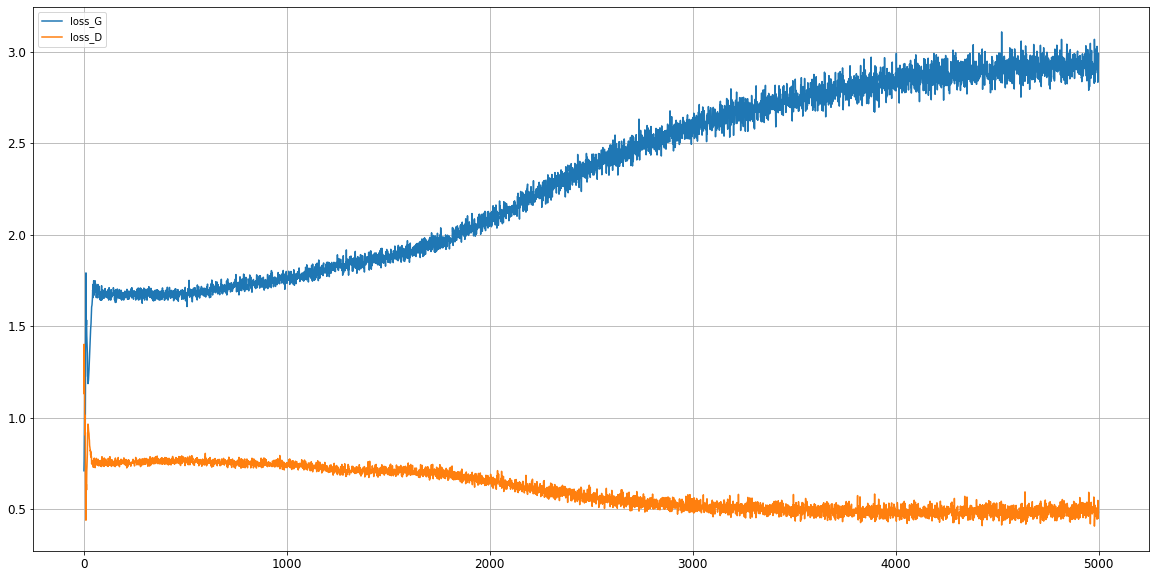

In [34]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_G', 'loss_D'])
#ax.set_yscale('log')
ax.grid()

In [35]:
import joblib
joblib.dump(scaler, "models/scaler-deriv-4.pkl")
gan.save("models/gan-deriv-4.h5")

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

noise = tf.random.normal(shape=[1, latent_space])
X_generated = scaler.inverse_transform(gan.layers[0].predict(noise).reshape(ntimes, ninput))

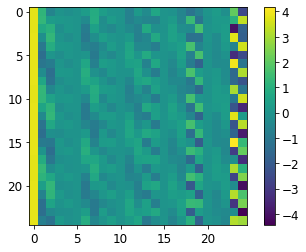

In [37]:
plt.imshow(X_generated)
plt.colorbar()

In [38]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0

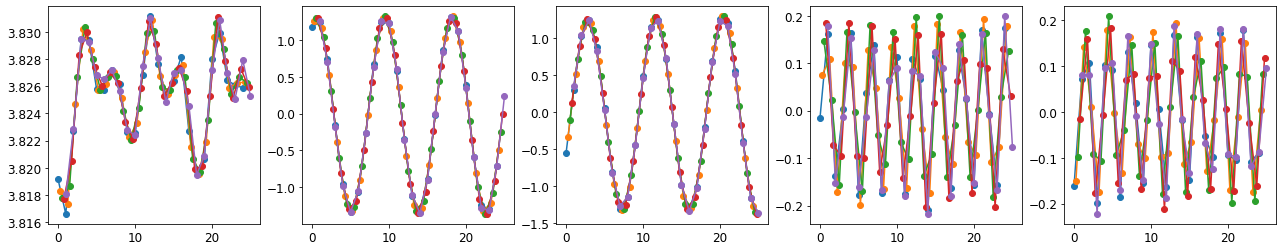

In [39]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,ntimes*nstep,nstep), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,ntimes*nstep+step,nstep), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,ntimes*nstep+step*2,nstep), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,ntimes*nstep+step*3,nstep), X_3[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*4,ntimes*nstep+step*4,nstep), X_4[:,i], '-o')

## Predict with the GAN

### Predict one point

**In this section we data assimilated the first 8 points generated by the GAN and predict the 9th**

**We use the singular values as weights for the optimization**

In [34]:
df = pd.read_table(data_dir + 'singular_values_1.dat', sep = ',', header=None, engine='python', comment = '#')
 
df.columns = (['index', 's_values', 'normalised s_values', 'cumulative energy'])
df.head()

index   s_values  normalised s_values  cumulative energy
0      0  170.97800             1.000000           0.892148
1      1   40.37620             0.236149           0.941899
2      2   39.52840             0.231190           0.989584
3      3    5.39844             0.031574           0.990473
4      4    5.28227             0.030894           0.991325

In [35]:
#weight = tf.constant(pca_compress.singular_values_, dtype=tf.float32)
values = df.values[:, 1].astype(np.float32)
weight = values[:ninput]
weight

array([170.978  ,  40.3762 ,  39.5284 ,   5.39844,   5.28227,   5.09296,
         4.98075,   4.80741,   4.5183 ,   4.44503,   4.39604,   3.81641,
         3.52731,   3.47671,   3.11096,   2.97483,   2.78567,   2.65468,
         2.54914,   2.32886,   2.219  ,   2.14945,   2.1285 ,   2.0595 ,
         1.83547], dtype=float32)

In [36]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(5e-2)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, ninput])*tf.math.sqrt(loss_weight)
    outp = tf.reshape(outp, [-1, ninput])*tf.math.sqrt(loss_weight)
    return mse(inp, outp)

In [37]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [38]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(5000):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

Loss:  0.0007853792
<tf.Variable 'Variable:0' shape=(1, 100) dtype=float32, numpy=
array([[-0.3318164 , -0.4951111 , -1.41876   , -0.04000768, -2.7085361 ,
        -2.7127068 , -0.6122486 , -0.9526119 ,  0.5998585 ,  0.08871505,
        -1.3120557 ,  0.91928405, -0.78421175, -1.2447586 , -0.5038871 ,
        -0.98353183, -0.6343118 , -1.9818358 ,  0.5114337 ,  0.06902641,
        -0.534843  , -0.1752043 ,  1.125792  , -0.35648742,  0.7942655 ,
        -1.7125599 ,  0.58473957,  0.31561896,  1.0662752 , -1.1397656 ,
         0.57807976, -0.21119918, -2.3445535 ,  0.73208886, -0.17665216,
         1.99025   , -0.34598446, -0.9494202 , -1.3813566 ,  0.16005802,
         3.8191738 ,  2.7605972 ,  1.1466743 ,  1.9038732 ,  1.7088672 ,
        -1.0250664 , -0.25851864,  0.55540633, -1.5565594 ,  0.73801655,
        -0.89630497,  1.1250012 , -0.5119395 , -0.05869196, -1.5494528 ,
        -0.41838434, -0.88072956, -0.7029571 ,  0.2706821 ,  1.3978208 ,
        -0.0083998 ,  0.0339426 , -2.0868

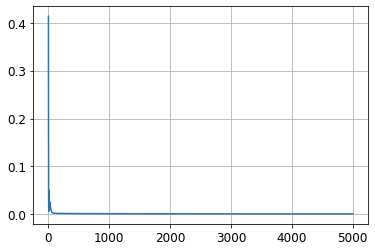

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

n = 500
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = optimize_coding(real_coding, weight)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())
print(latent_values)

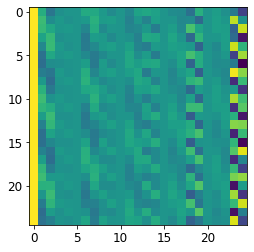

In [40]:
X_generated = scaler.inverse_transform(generator.predict(
    tf.convert_to_tensor(latent_values)).reshape(ntimes,ninput))
plt.imshow(X_generated)

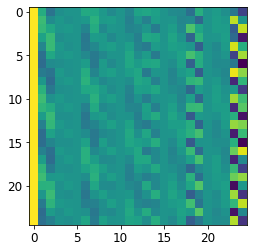

In [41]:
X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,ninput))
plt.imshow(X_real)

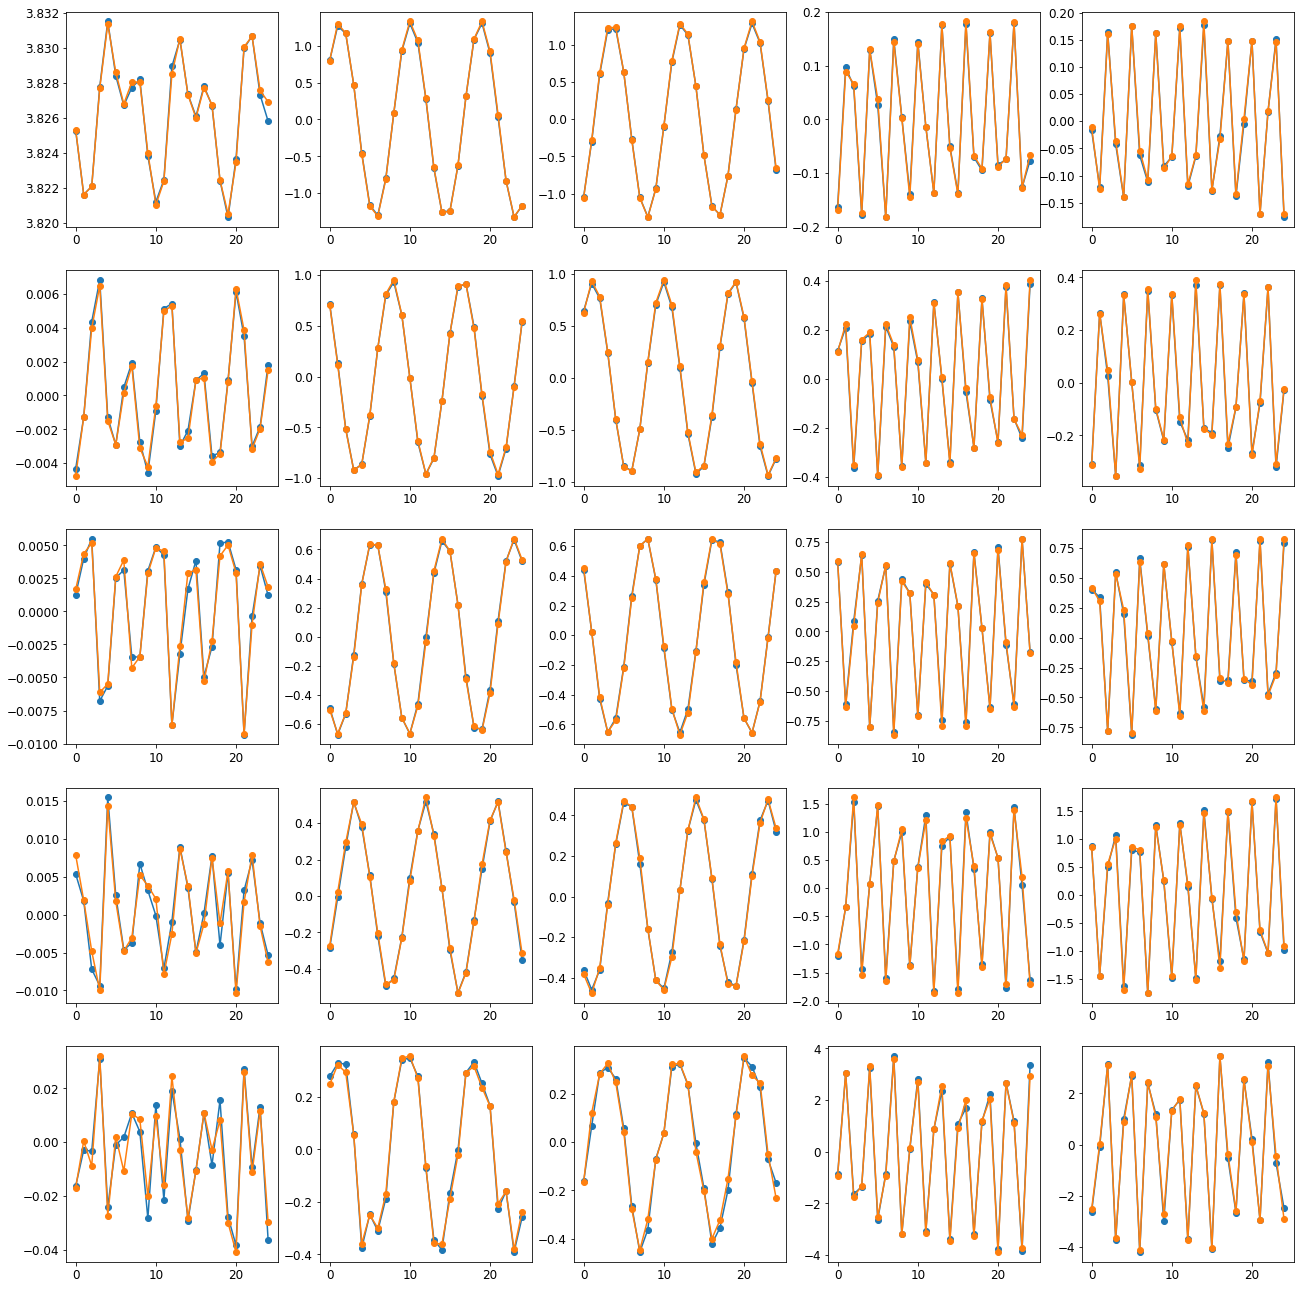

In [42]:
fig, ax = plt.subplots(5, 5, figsize=[22, 23])
for i in range(5):
    ax.flatten()[i].plot(X_generated[:,i], '-o')
    ax.flatten()[i].plot(X_real[:,i],'-o')

    ax.flatten()[i+5].plot(X_generated[:,i+5], '-o')
    ax.flatten()[i+5].plot(X_real[:,i+5],'-o')

    ax.flatten()[i+10].plot(X_generated[:,i+10], '-o')
    ax.flatten()[i+10].plot(X_real[:,i+10],'-o')
    
    ax.flatten()[i+15].plot(X_generated[:,i+15], '-o')
    ax.flatten()[i+15].plot(X_real[:,i+15],'-o')
    
    ax.flatten()[i+20].plot(X_generated[:,i+20], '-o')
    ax.flatten()[i+20].plot(X_real[:,i+20],'-o')

**The figure below shows the difference between the predicted and real data**

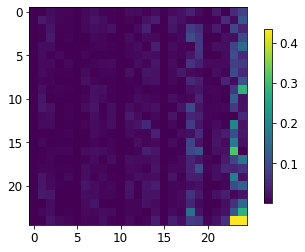

In [43]:
error = X_generated-X_real
plt.imshow(abs(error))
plt.colorbar(shrink=0.8)

**The figure below shows the first 8 points after the data assimilation and the 9th point as a prediction compared with real data**

In [44]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0

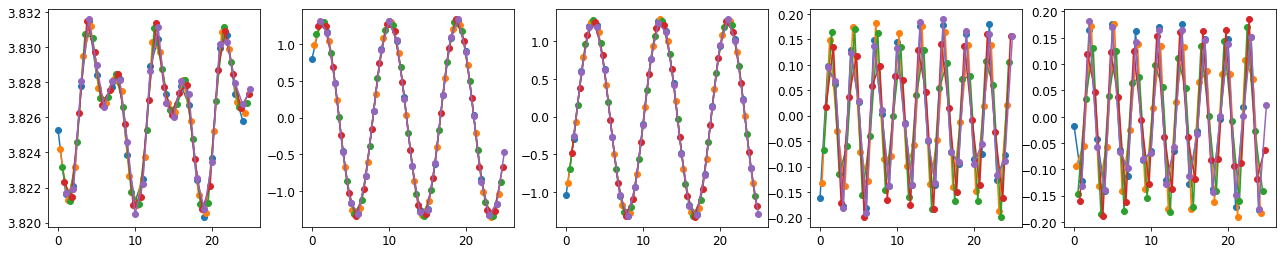

In [45]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,ntimes*nstep,nstep), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,ntimes*nstep+step,nstep), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,ntimes*nstep+step*2,nstep), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,ntimes*nstep+step*3,nstep), X_3[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*4,ntimes*nstep+step*4,nstep), X_4[:,i], '-o')

## Predict multiple points
In this section we predict multiple points. We use the last predictions as the points to data assimilate in the next prediction.

In [46]:
def optimize_coding(latent_values, real_coding, loss_weight, epochs=1000):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, loss_weight)
        
    return latent_values  #returns the optimized input that generates the desired output

### Start point = time step 500

In [47]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

n = 500
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,ninput))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(20): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)
X_generated = scaler.inverse_transform(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====


The figure below shows the prediction for 3 days in one point of the mesh

In [55]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0

In [56]:
t_end = (ntimes+20)*nstep
a_end = (ntimes-1)*nstep
nt_end = np.int(n+t_end*level_step)
na_end = np.int(n+a_end*level_step)

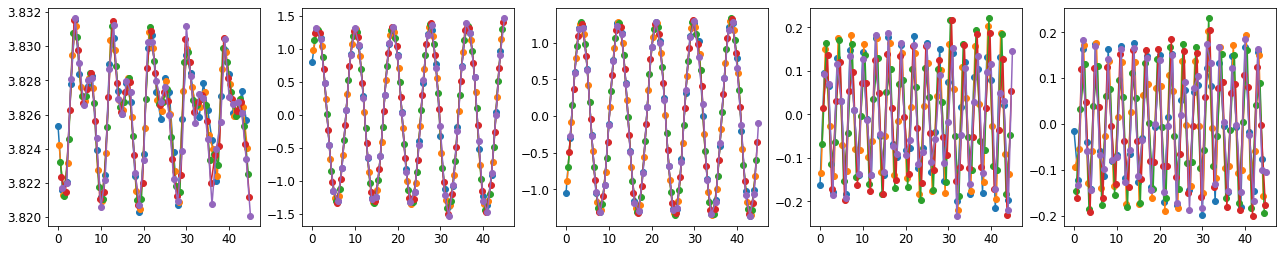

In [57]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,t_end,nstep), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,t_end+step,nstep), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,t_end+step*2,nstep), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,t_end+step*3,nstep), X_3[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*4,t_end+step*4,nstep), X_4[:,i], '-o')

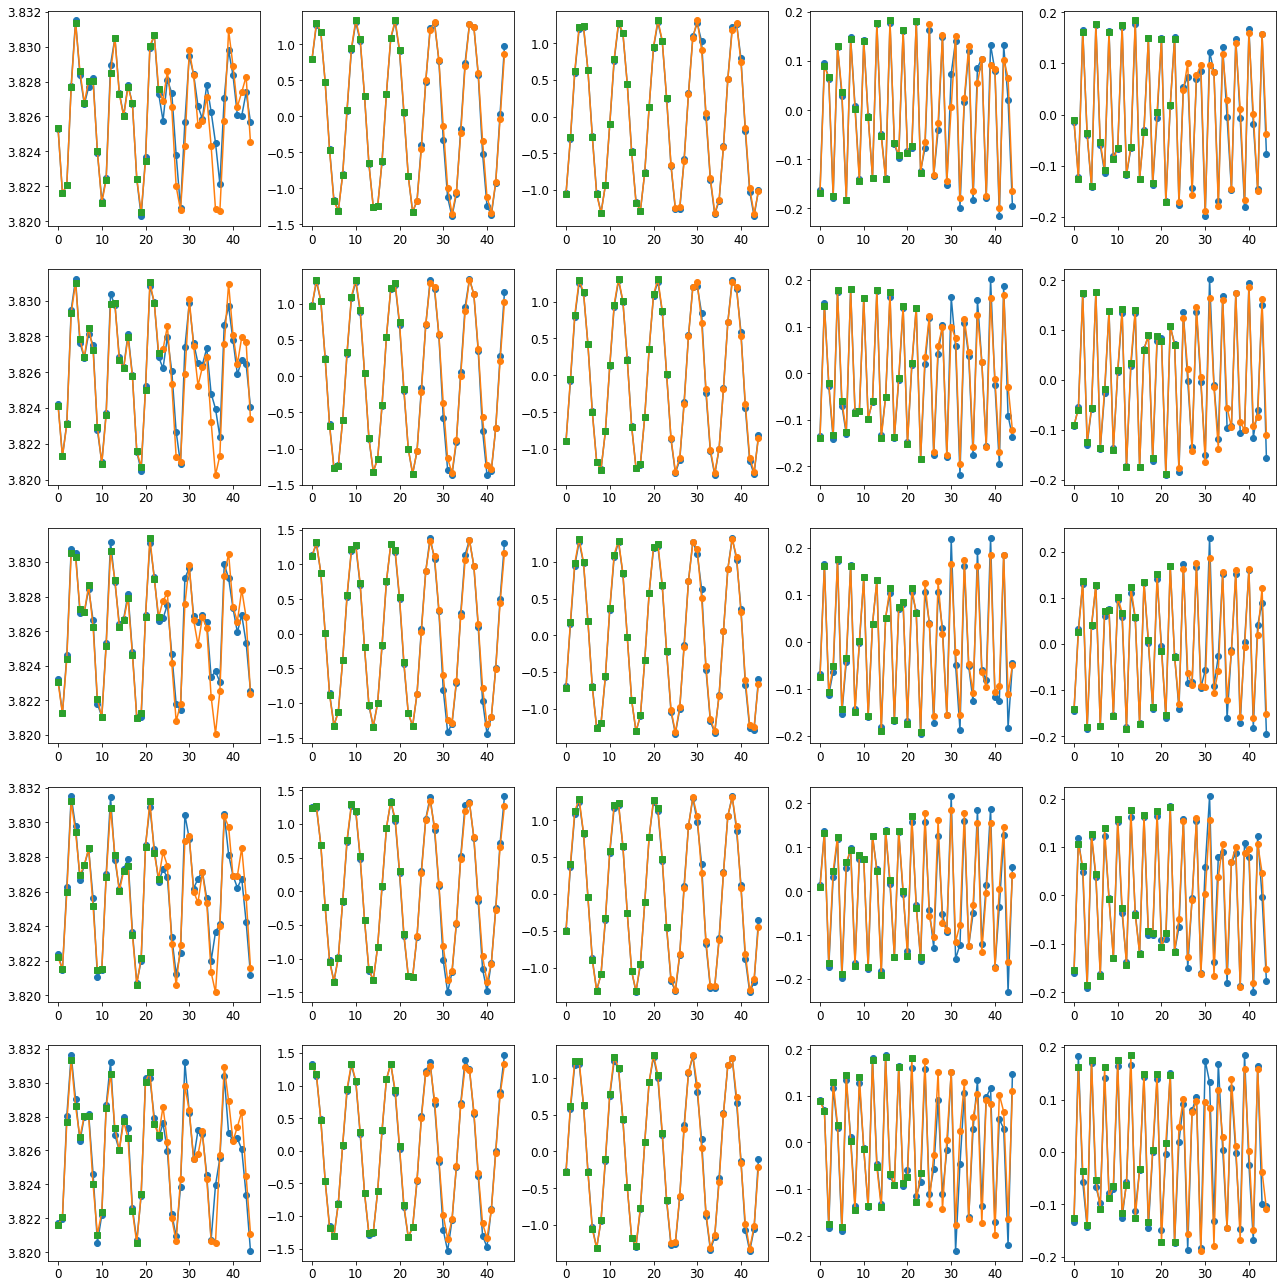

In [58]:
fig, ax = plt.subplots(5, 5, figsize=[22, 23])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,t_end,nstep), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(0,t_end,nstep),X_pod[n:nt_end:level_step,i],'-o')
    ax.flatten()[i].plot(np.arange(0,a_end,nstep),X_pod[n:na_end:level_step,i],'s')
    
    ax.flatten()[i+5].plot(np.arange(0,t_end,nstep), X_1[:,i], '-o')
    ax.flatten()[i+5].plot(np.arange(0,t_end,nstep), X_pod[n+1:nt_end+1:level_step,i],'-o')
    ax.flatten()[i+5].plot(np.arange(0,a_end,nstep), X_pod[n+1:na_end+1:level_step,i],'s')

    ax.flatten()[i+10].plot(np.arange(0,t_end,nstep), X_2[:,i], '-o')
    ax.flatten()[i+10].plot(np.arange(0,t_end,nstep), X_pod[n+2:nt_end+2:level_step,i],'-o')
    ax.flatten()[i+10].plot(np.arange(0,a_end,nstep), X_pod[n+2:na_end+2:level_step,i],'s')
    
    ax.flatten()[i+15].plot(np.arange(0,t_end,nstep), X_3[:,i], '-o')
    ax.flatten()[i+15].plot(np.arange(0,t_end,nstep), X_pod[n+3:nt_end+3:level_step,i],'-o')
    ax.flatten()[i+15].plot(np.arange(0,a_end,nstep), X_pod[n+3:na_end+3:level_step,i],'s')
    
    ax.flatten()[i+20].plot(np.arange(0,t_end,nstep), X_4[:,i], '-o')
    ax.flatten()[i+20].plot(np.arange(0,t_end,nstep), X_pod[n+4:nt_end+4:level_step,i],'-o')
    ax.flatten()[i+20].plot(np.arange(0,a_end,nstep), X_pod[n+4:na_end+4:level_step,i],'s')

## Predict the whole simulation

### Start point = time step 100

In [48]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

n = 100
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,ninput))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(200): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====
=====20=====
=====21=====
=====22=====
=====23=====
=====24=====
=====25=====
=====26=====
=====27=====
=====28=====
=====29=====
=====30=====
=====31=====
=====32=====
=====33=====
=====34=====
=====35=====
=====36=====
=====37=====
=====38=====
=====39=====
=====40=====
=====41=====
=====42=====
=====43=====
=====44=====
=====45=====
=====46=====
=====47=====
=====48=====
=====49=====
=====50=====
=====51=====
=====52=====
=====53=====
=====54=====
=====55=====
=====56=====
=====57=====
=====58=====
=====59=====
=====60=====
=====61=====
=====62=====
=====63=====
=====64=====
=====65=====
=====66=====
=====67=====
=====68=====
=====69=====
=====70=====
=====71=====
=====72=====
=====73=====
=====74=====
=====75=====
=====76=====
=====77==

In [51]:
X_generated = scaler.inverse_transform(X_predict)
np.save('X_deriv_4_100.npy',X_generated)

In [54]:
X0_0 = X_pod[100:1000:4]
X0_1 = X_pod[101:1001:4]
X0_2 = X_pod[102:1002:4]
X0_3 = X_pod[103:1003:4]
X0_4 = X_pod[104:1004:4]
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0

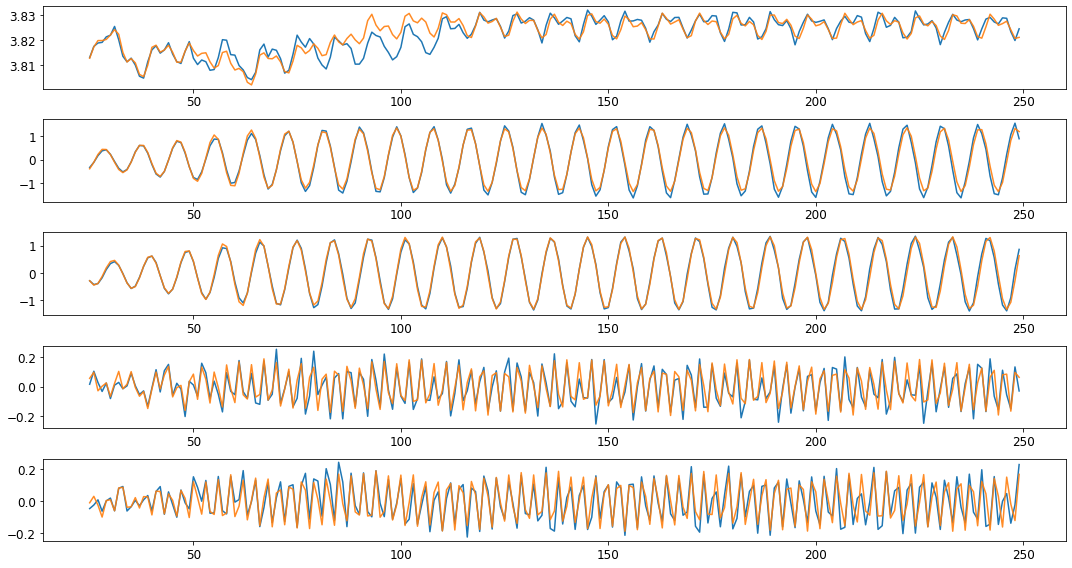

In [55]:
fig, ax = plt.subplots(5,1, figsize=[15,8])
for i in range(5):
    ax.flatten()[i].plot(times[100:1000:4], X_4[:,i])
    ax.flatten()[i].plot(times[100:1000:4], X0_4[:,i], alpha=0.9)

plt.tight_layout()
#plt.savefig('GAN_0-end_p4.png')

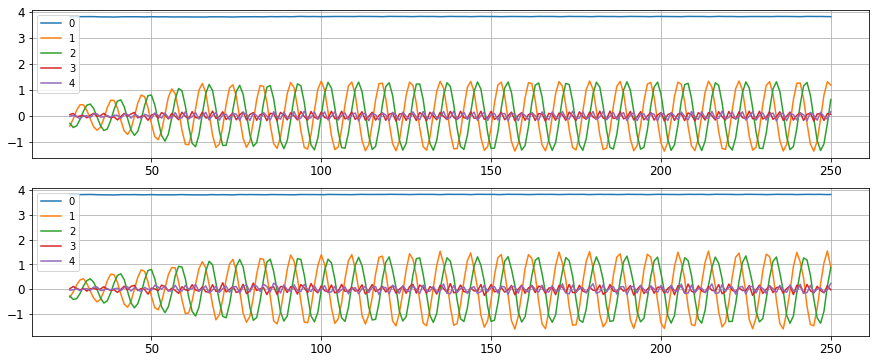

In [56]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(times[104:1004:4], X0_4)
ax[0].grid()
ax[0].legend(range(5))

ax[1].plot(times[104:1004:4], X_4)
ax[1].grid()
ax[1].legend(range(5))

Calculate error and relative error

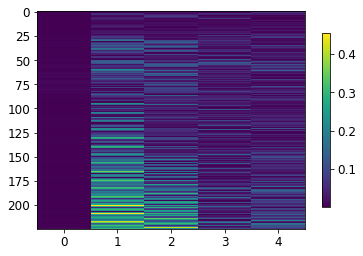

In [57]:
X_true = X0_4
X_pred = X_4
error = X_pred-X_true
relative_error = error/X_true
plt.imshow(abs(error), aspect='auto', interpolation='None')
plt.colorbar(shrink=0.8)

Calculate prediction RMSE

In [58]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
#config.prediction_rmse = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.0922


### Start point = time step 1000

In [59]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,ninput))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(200): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====
=====20=====
=====21=====
=====22=====
=====23=====
=====24=====
=====25=====
=====26=====
=====27=====
=====28=====
=====29=====
=====30=====
=====31=====
=====32=====
=====33=====
=====34=====
=====35=====
=====36=====
=====37=====
=====38=====
=====39=====
=====40=====
=====41=====
=====42=====
=====43=====
=====44=====
=====45=====
=====46=====
=====47=====
=====48=====
=====49=====
=====50=====
=====51=====
=====52=====
=====53=====
=====54=====
=====55=====
=====56=====
=====57=====
=====58=====
=====59=====
=====60=====
=====61=====
=====62=====
=====63=====
=====64=====
=====65=====
=====66=====
=====67=====
=====68=====
=====69=====
=====70=====
=====71=====
=====72=====
=====73=====
=====74=====
=====75=====
=====76=====
=====77==

In [61]:
X_generated = scaler.inverse_transform(X_predict)
np.save('X_deriv_4_1000.npy',X_generated)

In [62]:
X0_0 = X_pod[1000:1900:4]
X0_1 = X_pod[1001:1901:4]
X0_2 = X_pod[1002:1902:4]
X0_3 = X_pod[1003:1903:4]
X0_4 = X_pod[1004:1904:4]
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0
# a_n+4
X_4 = step**4 * X_generated[:, 20:25] + 4*X_3 - 6*X_2 + 4*X_1 - X_0

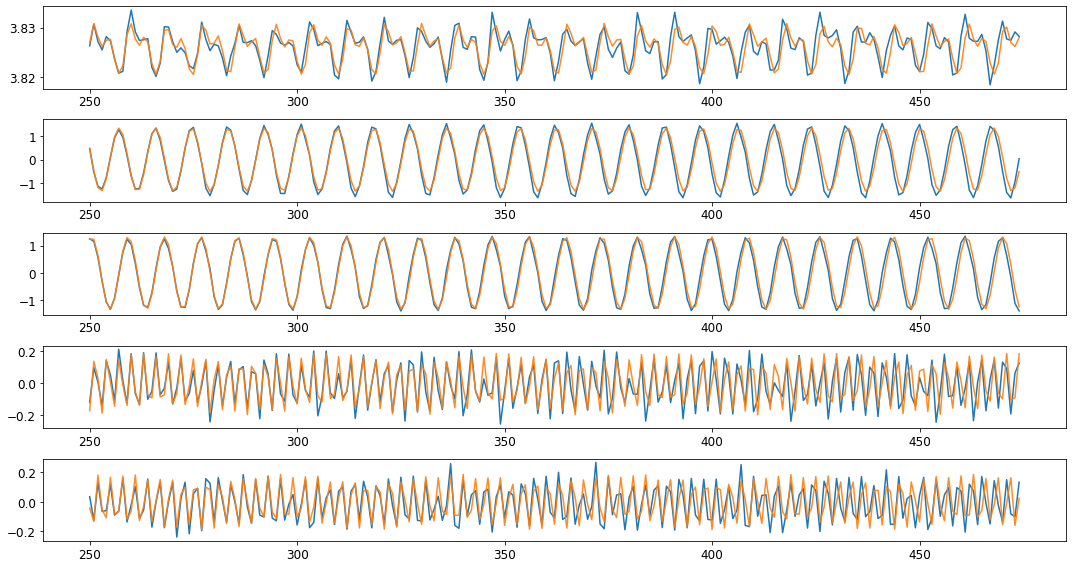

In [63]:
fig, ax = plt.subplots(5,1, figsize=[15,8])
for i in range(5):
    ax.flatten()[i].plot(times[1000:1900:4], X_4[:,i])
    ax.flatten()[i].plot(times[1000:1900:4], X0_4[:,i], alpha=0.9)

plt.tight_layout()
#plt.savefig('GAN_0-end_p4.png')

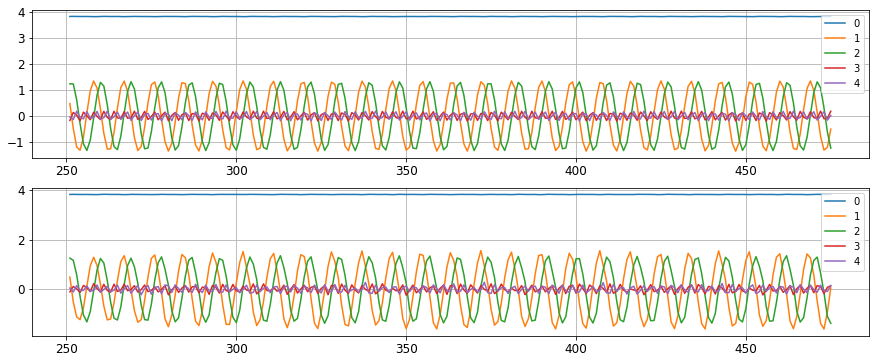

In [64]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(times[1004:1904:4], X_pod[1004:1904:4])
ax[0].grid()
ax[0].legend(range(5))

ax[1].plot(times[1004:1904:4], X_4)
ax[1].grid()
ax[1].legend(range(5))

Output as `csv`

In [137]:
out_dir = 'outputs/'
pod_coeffs_gen = np.transpose(X_5)
np.savetxt(out_dir+'pod_coeffs_gan_deriv_4.csv', pod_coeffs_gen , delimiter=',')
np.save(out_dir+'pod_coeffs_gan_deriv_4.npy', pod_coeffs_gen)

Calculate error and relative error

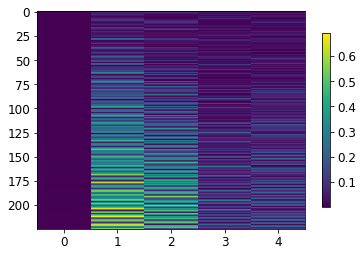

In [65]:
X_true = X0_4
X_pred = X_4
error = X_pred-X_true
relative_error = error/X_true
plt.imshow(abs(error), aspect='auto', interpolation='None')
plt.colorbar(shrink=0.8)

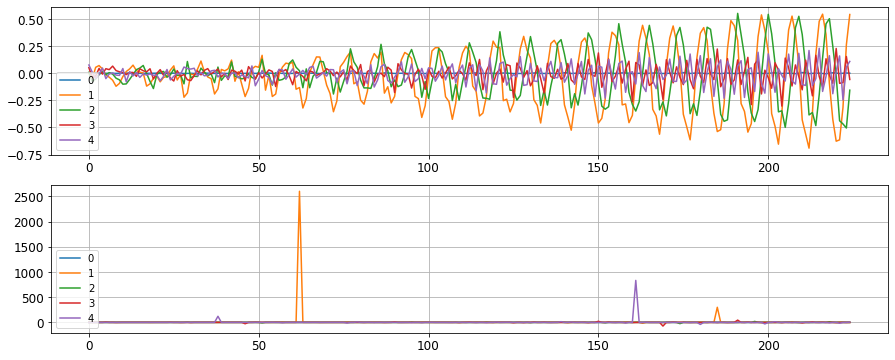

In [66]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(error);
ax[0].grid()
ax[0].legend(range(5),loc='lower left')

ax[1].plot(relative_error);
ax[1].grid()
ax[1].legend(range(5),loc='lower left')

Calculate prediction RMSE

In [67]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
#config.prediction_rmse = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.1666
